In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

In [2]:
# read sales data into a dataframe
df = pd.read_csv('RestaurantSales.csv')

In [3]:
from datetime import datetime
# parse to datetime type
df['Date']=pd.to_datetime(df['Date'],infer_datetime_format=True) 
df = df.set_index(['Date']) # set index variable as Date

In [4]:
# view top 5 entry values 
df.head()

,Sales
Date,
2021-05-02,33100
2021-06-02,36800
2021-07-02,48600
2021-08-02,31900
2021-09-02,28500


In [5]:
# check number of rows and columns present
df.shape

(92, 1)

The data contains 92 rowsa and a column.

In [6]:
# df summary
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 92 entries, 2021-05-02 to 2021-07-05
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Sales   92 non-null     int64
dtypes: int64(1)
memory usage: 1.4 KB


Column Sales contains no null value and is in the integer datatype

In [7]:
# statistical summary
df.describe()

,Sales
count,92.000000
mean,45223.369565
std,18625.494242
min,10000.000000
25%,30687.500000
50%,42400.000000
75%,57275.000000
max,92200.000000


* There are 92 records of sales i.e a record of almost 4 month sales
* An average total sale of approximately 45,223 by the Restaurant
* Minimum sale is 10,000 
* 75% of the sales data is about 57,275
* Highest Sale recoreded for the months is 92,200. That must have been a great day

In [8]:
# last rows of data
df.tail()

,Sales
Date,
2021-03-05,32400
2021-04-05,26150
2021-05-05,39600
2021-06-05,22000
2021-07-05,48450


Above shows that the record of Sales ends at the fifth month. It started at the second month according to head() function

### visuals of the data

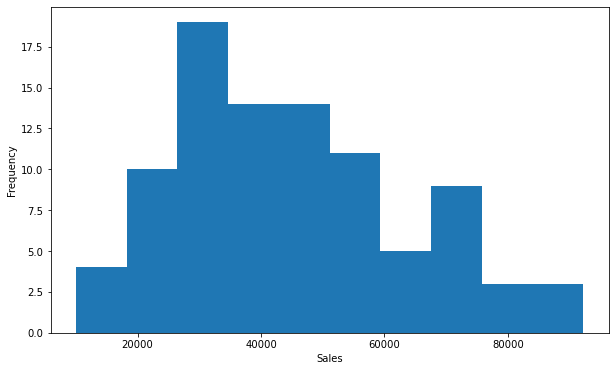

In [9]:
# histogram
plt.figure(figsize=(10, 6))
plt.hist(df['Sales']);
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()

<AxesSubplot:xlabel='Date'>

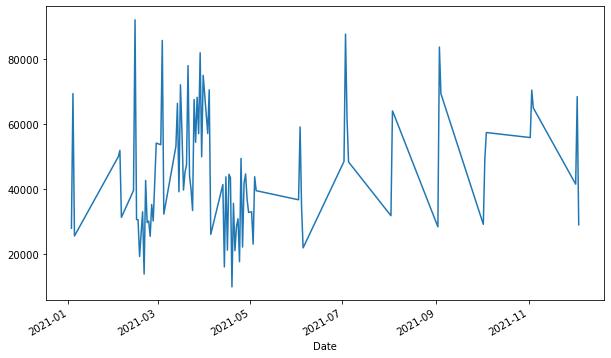

In [10]:
# view the trend and seasonality of the data
plt.figure(figsize=(10, 6))
df.Sales.plot()

The data does not tend to follow a seasonal pattern or trend.

In [11]:
# perform rolling statistics to see the variation of the mean and standard deviation.
rol_mean =df.rolling(window=12).mean()
rol_std =df.rolling(window=12).std()

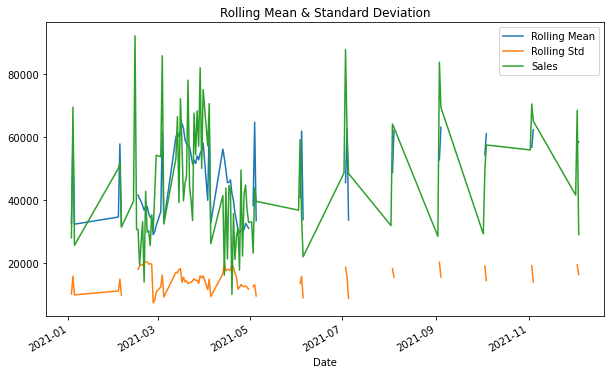

In [15]:
# plot rolling statistics
timeseries = df ['Sales']
plt.figure(figsize=(10, 6))
timeseries.rolling(12).mean().plot(label='Rolling Mean')
timeseries.rolling(12).std().plot(label='Rolling Std')
plt.title('Rolling Mean & Standard Deviation')
timeseries.plot()
plt.legend()

<AxesSubplot:xlabel='Date'>

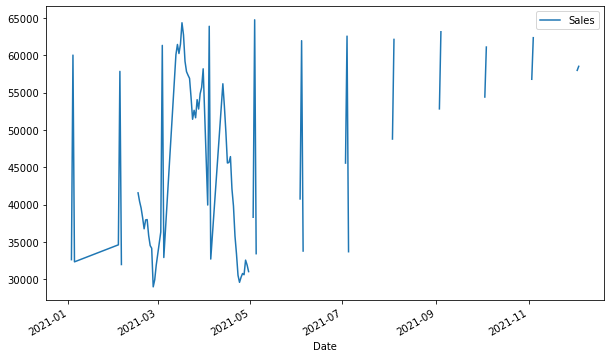

In [16]:
# plot rolling mean for better visual
rol_mean.plot(figsize=(10, 6))

The trend of  sales mean (average) can not be concluded to determine its stationarity. The Dickey-Fuller test (ADF) will be performed to check whether the data is stationary or not. It is used to test the null hypothesis.

In [17]:
# perform Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller

print('Result of ADF test: ')
dftest = adfuller(df['Sales'],autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['ADF test statistic','p-value','# of lags used','# of observations'])
for key,value in dftest[4].items():
    dfoutput['critical value (%s)' %key]=value
    
print(dfoutput)

Result of ADF test: 
ADF test statistic      -2.188368
p-value                  0.210494
# of lags used           5.000000
# of observations       86.000000
critical value (1%)     -3.508783
critical value (5%)     -2.895784
critical value (10%)    -2.585038
dtype: float64


It is clear that the data is non-stationary, the p-value is approximately 0.21. 

Take log of the data

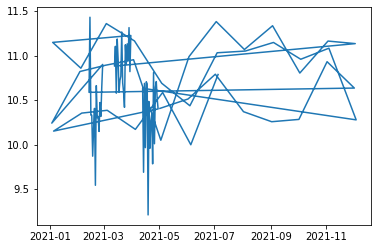

In [18]:
# estimating trend
df_logScale = np.log(df)
plt.plot(df_logScale)

In [19]:
# calculate rolling mean and standard deviation of logged data
movingAverage = df_logScale.rolling(window=12).mean()
movingSTD = df_logScale.rolling(window=12).std()

Apply differencing to make the data stationary. 

In [20]:
# subtract the rolling mean from logged data
dataLogScaleMinusMovingAverage = df_logScale - movingAverage
# remove Nan values
dataLogScaleMinusMovingAverage.dropna(inplace=True)
dataLogScaleMinusMovingAverage.head() # view first 5 rows

,Sales
Date,
2021-02-16,-0.242413
2021-02-17,-0.657617
2021-02-18,-0.322746
2021-02-19,-0.060774
2021-02-20,-0.855901


Build a function for further use to check the stationarity of the data; determine the rolling statistics and perform the dickey-fuller test

In [30]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    # determine rolling statistics:
    movingAverage=timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    # plot rolling mean
    #plt.plot(movingAverage)
    
    # perform dickey-fuller test
    print('Result of ADF test: ')
    dftest=adfuller(timeseries['Sales'])
    dfoutput=pd.Series(dftest[0:4], index=['ADF test statistic','p-value','# of lags used','# of observations'])
    for key,value in dftest[4].items():
        dfoutput['critical value (%s)' %key]=value
    
    print(dfoutput)

In [22]:
# use functtion on
test_stationarity(dataLogScaleMinusMovingAverage)

Result of ADF test: 
ADF test statistic      -2.630691
p-value                  0.086818
# of lags used           5.000000
# of observations       75.000000
critical value (1%)     -3.520713
critical value (5%)     -2.900925
critical value (10%)    -2.587781
dtype: float64


<AxesSubplot:xlabel='Date'>

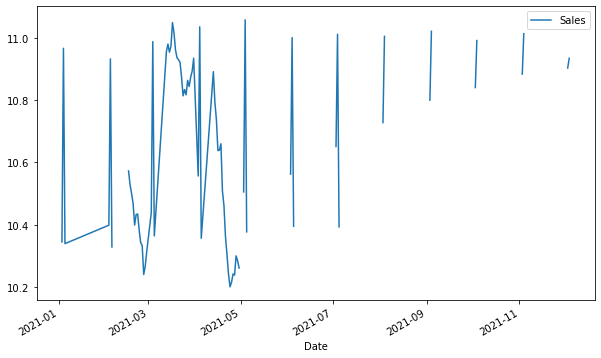

In [23]:
# plot rolling mean of logged data
movingAverage.plot(figsize=(10, 6))

In [24]:
# difference of logged data and shift
dataLogDiffShifting = df_logScale - df_logScale.shift()
dataLogDiffShifting.dropna(inplace=True)
test_stationarity(dataLogDiffShifting)

Result of ADF test: 
ADF test statistic     -7.880028e+00
p-value                 4.729976e-12
# of lags used          3.000000e+00
# of observations       8.700000e+01
critical value (1%)    -3.507853e+00
critical value (5%)    -2.895382e+00
critical value (10%)   -2.584824e+00
dtype: float64


In [25]:
# perform differencing on the data
dataDiffShifting = df - df.shift(1)
dataDiffShifting.dropna(inplace=True)
test_stationarity(dataDiffShifting)

Result of ADF test: 
ADF test statistic     -7.601628e+00
p-value                 2.380859e-11
# of lags used          3.000000e+00
# of observations       8.700000e+01
critical value (1%)    -3.507853e+00
critical value (5%)    -2.895382e+00
critical value (10%)   -2.584824e+00
dtype: float64


In [31]:
# perform second differencing on the original data
dataDiffShifting = df - df.shift(2)
dataDiffShifting.dropna(inplace=True)
test_stationarity(dataDiffShifting)

Result of ADF test: 
ADF test statistic      -2.482017
p-value                  0.119911
# of lags used          12.000000
# of observations       77.000000
critical value (1%)     -3.518281
critical value (5%)     -2.899878
critical value (10%)    -2.587223
dtype: float64


The p-value of the differenced data is approximately 0.12 i.e the lowest

View the seasonality trend and residuals by using ETS decomposition:

<Figure size 432x288 with 0 Axes>

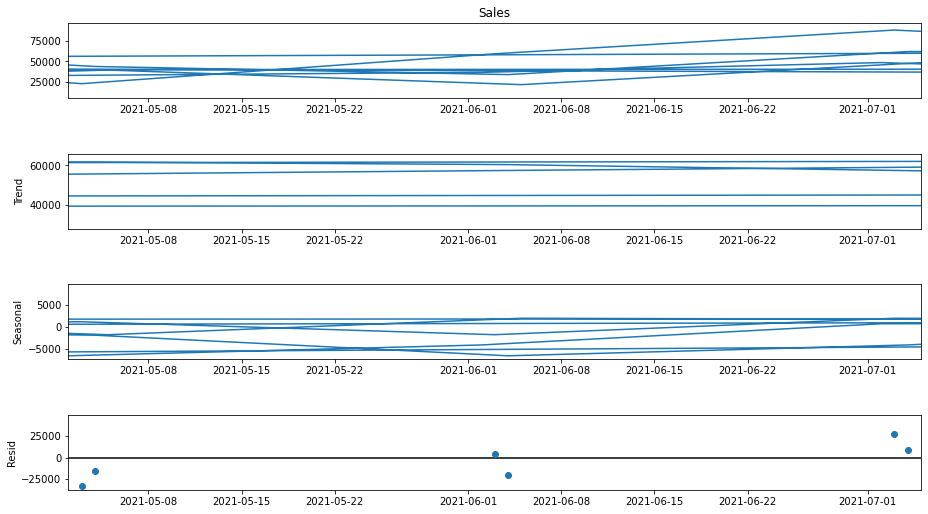

In [37]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df['Sales'], freq = 12)
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(15, 8)

In [38]:
# more import 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

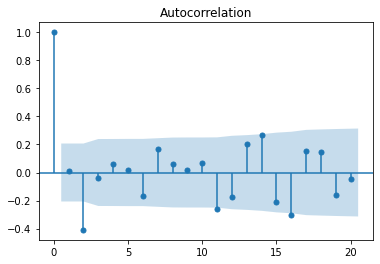

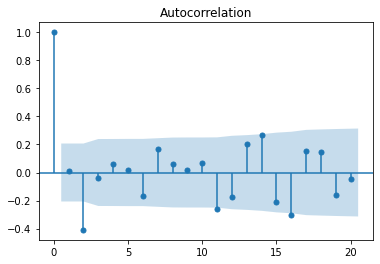

In [40]:
# plot acf to determine value q
plot_acf(dataDiffShifting)

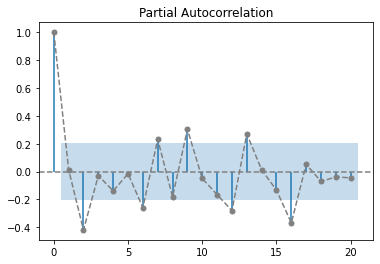

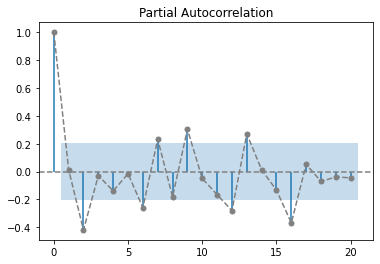

In [41]:
# plot pacf to identify the value of p
plot_pacf(dataDiffShifting, linestyle='--',color='gray')

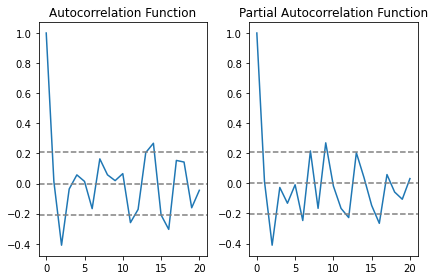

In [43]:
# ACF and PACF plots
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(dataDiffShifting, nlags=20)
lag_pacf = pacf(dataDiffShifting, nlags=20, method='ols')

# plot ACF
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(dataDiffShifting)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(dataDiffShifting)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

# plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(dataDiffShifting)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(dataDiffShifting)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

The data was not seasonal hence, the use of just ARIMA on it.

In [46]:
from statsmodels.tsa.arima_model import ARIMA
arima_model = ARIMA(df.Sales, (1,2,1)).fit()

print(arima_model.summary())

/Users/khaiyra/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/khaiyra/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:585: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'
/Users/khaiyra/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/khaiyra/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:585: ValueWarning: A date index has

                             ARIMA Model Results                              
Dep. Variable:               D2.Sales   No. Observations:                   90
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -1008.685
Method:                       css-mle   S.D. of innovations          17269.778
Date:                Wed, 26 May 2021   AIC                           2025.370
Time:                        00:38:45   BIC                           2035.369
Sample:                             2   HQIC                          2029.402
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -12.6886     44.870     -0.283      0.777    -100.632      75.255
ar.L1.D2.Sales    -0.5544      0.087     -6.343      0.000      -0.726      -0.383
ma.L1.D2.Sales    -1.0000      0.029

In [49]:
df

,Sales
Date,
2021-05-02,33100
2021-06-02,36800
2021-07-02,48600
2021-08-02,31900
2021-09-02,28500
...,...
2021-03-05,32400
2021-04-05,26150
2021-05-05,39600


/Users/khaiyra/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/Users/khaiyra/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/Users/khaiyra/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


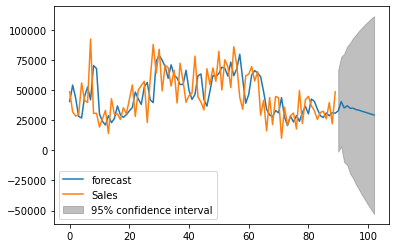

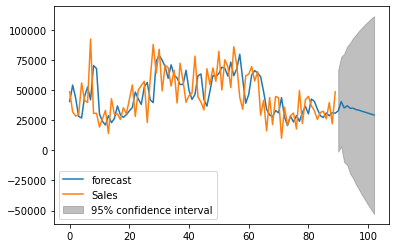

In [55]:
arima_model.plot_predict(2,104)

In [57]:
# forecast for a year
arima_model.forecast(steps=12)

(array([32769.4619615 , 40425.79672226, 35124.76441272, 36987.39671647,
        34858.868034  , 34923.26157298, 33752.20592784, 33246.34345733,
        32351.98395449, 31653.27890218, 30826.38268366, 30050.83089297]),
 array([17269.77831931, 18906.83083445, 22946.83136741, 25055.49868377,
        27649.32074969, 29679.31090253, 31753.84820548, 33608.8344238 ,
        35414.93903813, 37107.70409485, 38740.12428839, 40299.24487347]),
 array([[ -1078.68156533,  66617.60548833],
        [  3369.08922494,  77482.50421957],
        [ -9850.19862671,  80099.72745215],
        [-12120.47831841,  86095.27175135],
        [-19332.8048324 ,  89050.54090039],
        [-23247.11888195,  93093.6420279 ],
        [-28484.19292546,  95988.60478114],
        [-32625.7615757 ,  99118.44849035],
        [-37060.02107492, 101763.98898391],
        [-41076.4846727 , 104383.04247706],
        [-45102.8656782 , 106755.63104552],
        [-48934.2376632 , 109035.89944913]]))

### Questions
1. From the graph, it shows labels from january to November, whereas the data is from february till May
2. when i set the window size to 365, which is daily because the data is not even up to a year, it throws error
3. what p-value is appropriate to determinr if the data is stationary or not. I read it should be below 0.5 from one and another says below 0.05
4. How do i read values of p, d and q. It is somewhat confusing
5. Is the decomposition graph neccesary? because it looks kind of ugly